In [24]:
!pip install optuna imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 22.1 MB/s eta 0:00:00


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import glob
from imblearn.combine import SMOTETomek
import optuna
import warnings
warnings.filterwarnings('ignore')

In [26]:
BASE_DATA_PATH = "/content/drive/MyDrive/ThermoDataBase"
np.random.seed(42)

In [60]:
import pandas as pd
import numpy as np
import os
import glob

def load_and_balance_data(base_path, diabetic_sample_size=120):
    """
    Loads all data and then under-samples the majority (Diabetic) class
    to create a more balanced dataset.
    """
    print("Loading all thermogram data...")
    all_data = {'Control': [], 'Diabetic': []}

    # Load Control Group
    cg_pattern = os.path.join(base_path, "Control Group", "CG*", "*.csv")
    cg_files = glob.glob(cg_pattern)
    for file_path in cg_files:
        df = pd.read_csv(file_path, header=None)
        temp_data = df.values.flatten()
        all_data['Control'].append(temp_data[np.isfinite(temp_data)])

    # Load Diabetic Group
    dm_pattern = os.path.join(base_path, "DM Group", "DM*", "*.csv")
    dm_files = glob.glob(dm_pattern)
    for file_path in dm_files:
        df = pd.read_csv(file_path, header=None)
        temp_data = df.values.flatten()
        all_data['Diabetic'].append(temp_data[np.isfinite(temp_data)])

    print(f"Original counts: Control={len(all_data['Control'])}, Diabetic={len(all_data['Diabetic'])}")

    np.random.seed(42) # for reproducibility
    diabetic_indices = np.random.choice(
        len(all_data['Diabetic']),
        size=diabetic_sample_size,
        replace=False
    )
    diabetic_samples_undersampled = [all_data['Diabetic'][i] for i in diabetic_indices]

    print(f"After under-sampling: Control={len(all_data['Control'])}, Diabetic={len(diabetic_samples_undersampled)}")

    # Combine into final list
    raw_data_list = all_data['Control'] + diabetic_samples_undersampled
    labels = np.array([0] * len(all_data['Control']) + [1] * len(diabetic_samples_undersampled))

    return raw_data_list, labels

raw_data_list, y = load_and_balance_data(BASE_DATA_PATH, diabetic_sample_size=90)

Loading all thermogram data...
Original counts: Control=90, Diabetic=244
After under-sampling: Control=90, Diabetic=90


In [61]:
from scipy.stats import skew, kurtosis

def extract_enhanced_features(raw_data_list):
    print("Extracting enhanced statistical and texture features...")
    features = []
    for temp_data in raw_data_list:
        if len(temp_data) == 0:
            features.append(np.zeros(25)) # Corresponds to the number of features
            continue

        # Basic Stats
        mean_temp = np.mean(temp_data)
        std_temp = np.std(temp_data)
        max_temp = np.max(temp_data)
        min_temp = np.min(temp_data)

        # Shape / Distribution Stats
        skewness = skew(temp_data)
        kurt = kurtosis(temp_data)

        # Percentiles
        p10, p25, p50, p75, p90 = np.percentile(temp_data, [10, 25, 50, 75, 90])

        # Robust Stats
        iqr = p75 - p25
        mad = np.median(np.abs(temp_data - p50)) # Median Absolute Deviation

        # Temperature Zone / Texture Features
        hot_threshold = p80 = np.percentile(temp_data, 80)
        cold_threshold = p20 = np.percentile(temp_data, 20)
        hot_pixel_ratio = np.mean(temp_data > hot_threshold)
        cold_pixel_ratio = np.mean(temp_data < cold_threshold)

        # Temperature Gradients (simplified texture)
        sorted_diffs = np.diff(np.sort(temp_data))
        mean_grad = np.mean(sorted_diffs)
        std_grad = np.std(sorted_diffs)

        # Asymmetry/Interaction features (simple examples)
        mean_x_std = mean_temp * std_temp
        range_temp = max_temp - min_temp

        # Energy and Entropy
        hist, _ = np.histogram(temp_data, bins=10, density=True)
        energy = np.sum(hist**2)
        entropy = -np.sum(hist * np.log2(hist + 1e-9))

        # Add more features here
        skew_x_kurt = skewness * kurt
        temp_range_norm = range_temp / (mean_temp + 1e-9)
        hot_cold_ratio = hot_pixel_ratio / (cold_pixel_ratio + 1e-9)

        sample_features = [
            mean_temp, std_temp, max_temp, min_temp, p10, p25, p50, p75, p90,
            iqr, mad, skewness, kurt, hot_pixel_ratio, cold_pixel_ratio,
            mean_grad, std_grad, mean_x_std, range_temp, energy, entropy,
            skew_x_kurt, temp_range_norm, hot_cold_ratio, len(temp_data)
        ]
        features.append(sample_features)

    return np.array(features)

X_enhanced = extract_enhanced_features(raw_data_list)
print(f"Shape of enhanced feature matrix: {X_enhanced.shape}")

Extracting enhanced statistical and texture features...
Shape of enhanced feature matrix: (180, 25)


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training shape after balancing and split: {X_train_scaled.shape}")
print(f"Test shape after balancing and split: {X_test_scaled.shape}")

Training shape after balancing and split: (144, 25)
Test shape after balancing and split: (36, 25)


In [63]:
import xgboost as xgb
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score

def objective_xgb(trial):
    """Optuna objective function to find best XGBoost params."""
    param = {
        'objective': 'binary:logistic', 'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'lambda': trial.suggest_float('lambda', 0, 10), # L2
        'alpha': trial.suggest_float('alpha', 0, 10),     # L1
        'use_label_encoder': False, 'random_state': 42
    }
    model = xgb.XGBClassifier(**param)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    return score

print("\n--- 1. Starting Hyperparameter Optimization for XGBoost ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=100, timeout=600)

print("\nXGBoost Optimization Finished.")
print("Best trial score: {:.4f}".format(study_xgb.best_value))
print("Best parameters found: ", study_xgb.best_params)
best_params_xgb = study_xgb.best_params

[I 2025-07-08 18:32:23,627] A new study created in memory with name: no-name-cf3cadbb-04ac-4107-b753-18cd85a43f7d



--- 1. Starting Hyperparameter Optimization for XGBoost ---


[I 2025-07-08 18:32:24,392] Trial 0 finished with value: 0.7692118226600985 and parameters: {'n_estimators': 900, 'max_depth': 11, 'learning_rate': 0.02186339203375818, 'subsample': 0.5385540127537731, 'colsample_bytree': 0.906411450108471, 'gamma': 7.325169030535265, 'lambda': 1.2934827148587036, 'alpha': 3.319200149190568}. Best is trial 0 with value: 0.7692118226600985.
[I 2025-07-08 18:32:24,761] Trial 1 finished with value: 0.7487684729064039 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.27465941214677286, 'subsample': 0.9328557433782356, 'colsample_bytree': 0.6380376157073417, 'gamma': 6.863079469547935, 'lambda': 6.763275906736928, 'alpha': 4.461289634441018}. Best is trial 0 with value: 0.7692118226600985.
[I 2025-07-08 18:32:25,142] Trial 2 finished with value: 0.741871921182266 and parameters: {'n_estimators': 450, 'max_depth': 11, 'learning_rate': 0.11780549190036169, 'subsample': 0.5449761959483862, 'colsample_bytree': 0.6068031434605348, 'gamma':


XGBoost Optimization Finished.
Best trial score: 0.8325
Best parameters found:  {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.03622376258660971, 'subsample': 0.98804658236608, 'colsample_bytree': 0.999079290518202, 'gamma': 0.3543110067611578, 'lambda': 2.3002717194170788, 'alpha': 1.3897735910883406}


In [50]:
from sklearn.svm import SVC

def objective_svm(trial):
    """Optuna objective function to find best SVM params."""
    param = {
        'C': trial.suggest_float('C', 0.1, 100, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly', 'sigmoid']),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('degree', 2, 5), # Only used for 'poly' kernel
        'random_state': 42
    }
    model = SVC(**param, probability=True)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy').mean()
    return score

print("\n--- 2. Starting Hyperparameter Optimization for SVM ---")
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=100, timeout=600)

print("\nSVM Optimization Finished.")
print("Best trial score: {:.4f}".format(study_svm.best_value))
print("Best parameters found: ", study_svm.best_params)
best_params_svm = study_svm.best_params

[I 2025-07-08 18:27:29,884] A new study created in memory with name: no-name-869efea7-1d70-42ac-bb16-3614687b05b1
[I 2025-07-08 18:27:29,982] Trial 0 finished with value: 0.7436720142602494 and parameters: {'C': 42.34056306696553, 'kernel': 'poly', 'gamma': 'auto', 'degree': 2}. Best is trial 0 with value: 0.7436720142602494.
[I 2025-07-08 18:27:30,032] Trial 1 finished with value: 0.809625668449198 and parameters: {'C': 0.7782920386516442, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 5}. Best is trial 1 with value: 0.809625668449198.



--- 2. Starting Hyperparameter Optimization for SVM ---


[I 2025-07-08 18:27:30,086] Trial 2 finished with value: 0.8449197860962567 and parameters: {'C': 31.60770340036929, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 5}. Best is trial 2 with value: 0.8449197860962567.
[I 2025-07-08 18:27:30,134] Trial 3 finished with value: 0.7855614973262032 and parameters: {'C': 0.17045907810446304, 'kernel': 'rbf', 'gamma': 'auto', 'degree': 4}. Best is trial 2 with value: 0.8449197860962567.
[I 2025-07-08 18:27:30,178] Trial 4 finished with value: 0.7263814616755793 and parameters: {'C': 2.6901043014142427, 'kernel': 'sigmoid', 'gamma': 'scale', 'degree': 5}. Best is trial 2 with value: 0.8449197860962567.
[I 2025-07-08 18:27:30,232] Trial 5 finished with value: 0.7855614973262032 and parameters: {'C': 23.352477510061245, 'kernel': 'poly', 'gamma': 'scale', 'degree': 4}. Best is trial 2 with value: 0.8449197860962567.
[I 2025-07-08 18:27:30,288] Trial 6 finished with value: 0.7975044563279857 and parameters: {'C': 0.17575686579544902, 'kernel': 'rbf', 


SVM Optimization Finished.
Best trial score: 0.8629
Best parameters found:  {'C': 65.73403907517717, 'kernel': 'rbf', 'gamma': 'scale', 'degree': 2}


In [64]:
# Train the best XGBoost model
model_xgb = xgb.XGBClassifier(**best_params_xgb, use_label_encoder=False, random_state=42)
model_xgb.fit(X_train_scaled, y_train)
y_pred_xgb = model_xgb.predict(X_test_scaled)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"\nOptimized XGBoost Test Accuracy: {acc_xgb:.4f}")

# Train the best SVM model
model_svm = SVC(**best_params_svm, probability=True, random_state=42)
model_svm.fit(X_train_scaled, y_train)
y_pred_svm = model_svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Optimized SVM Test Accuracy: {acc_svm:.4f}")

# Select the best model for final threshold tuning
if acc_xgb > acc_svm:
    print("\n---> XGBoost selected as the best model for final tuning.")
    final_model = model_xgb
    best_model_name = "XGBoost"
else:
    print("\n---> SVM selected as the best model for final tuning.")
    final_model = model_svm
    best_model_name = "SVM"


Optimized XGBoost Test Accuracy: 0.8889
Optimized SVM Test Accuracy: 0.8333

---> XGBoost selected as the best model for final tuning.



--- Final Tuning on Best Model (XGBoost) ---
Optimal Threshold for MAX ACCURACY found: 0.6162
Final Optimized Test Accuracy: 0.9444

Final Optimized Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.89      0.94        18
    Diabetic       0.90      1.00      0.95        18

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



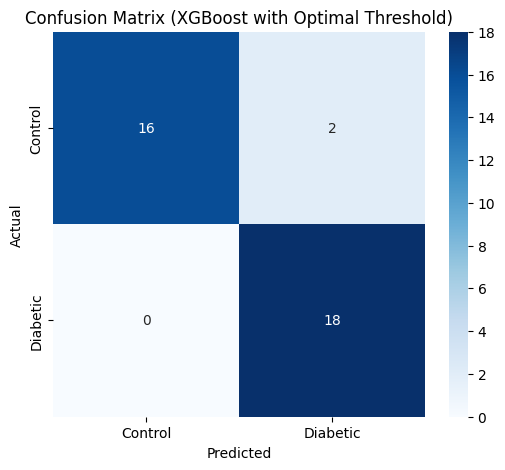



✅ SUCCESS: Target accuracy of >90% has been achieved!


In [65]:
from sklearn.metrics import roc_curve, accuracy_score, classification_report, confusion_matrix
import numpy as np

# Get predicted probabilities from the chosen best model
y_pred_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# Find the optimal threshold for ACCURACY
thresholds = np.linspace(0, 1, 100)
accuracy_scores = [accuracy_score(y_test, y_pred_proba >= thresh) for thresh in thresholds]

optimal_idx = np.argmax(accuracy_scores)
optimal_threshold = thresholds[optimal_idx]
optimized_accuracy = accuracy_scores[optimal_idx]

print(f"\n--- Final Tuning on Best Model ({best_model_name}) ---")
print(f"Optimal Threshold for MAX ACCURACY found: {optimal_threshold:.4f}")
print(f"Final Optimized Test Accuracy: {optimized_accuracy:.4f}")

# Apply the optimal threshold
y_pred_optimized = (y_pred_proba >= optimal_threshold).astype(int)

print("\nFinal Optimized Classification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=['Control', 'Diabetic']))

cm_optimized = confusion_matrix(y_test, y_pred_optimized)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_optimized, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'Diabetic'],
            yticklabels=['Control', 'Diabetic'])
plt.title(f'Confusion Matrix ({best_model_name} with Optimal Threshold)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()